## Globals

In [21]:
import matplotlib
matplotlib.use("svg")
from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import numpy as np
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
from Bio import SeqIO
import re
import scipy

matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('font', size=9)
matplotlib.rc('xtick', labelsize=7)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=7)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=9)

matplotlib.rc('axes', linewidth=.6)
matplotlib.rc('xtick.major', width=.6)
matplotlib.rc('xtick.major', size=2.5)
matplotlib.rc('ytick.major', width=.6)

matplotlib.rc('ytick.major', size=2.5)

import glob
import dms_tools
import dms_tools.file_io
import dms_tools.utils
from pyfaidx import Fasta


## Below is the analysis of the cell culture and mouse competition assays of wt NA and 1wt43GUA or 1wtUUA to see if having an ATG at position 43 confers a fitness advantage

We processed the sequencing reads to determine the frequency of the wildtype NA and mutant NA in each competition as follows. To determine the frequency of wildtype NA, we aligned our samples to the 1wt 43wt sequence, and counted the number of reads containing AUG at coding nucleotides 43-45. To determine the frequency of mutant NA, we aligned our samples to etiher the 1wt43GUA or 1wt43UUA sequence, and counted the number of reads containing GUA or UUA at coding nucleotides 43-45. We used dms tools for alignment of sequence data, and allowed only 2 nucleotide mismatches over coding nucleotides 1-48.

To examine if there is an enrichment of wildtype viruses mutant over time, we first calculated the ratio of wildtype verses mutant at each timepoint using the counts of AUG, UUA, or GUA codons at postion 43-45. We then calculated the enrichment of wildtype relative to mutant over time. To do this we divided the ratio of wildtype to mutant at the endpoint (either 72 hr cell-culture or mouse value) by the ratio of wildtype to mutant at the 10 hr cell-culture timepoint. We compared the endpoint to the 10 hr timepoint instead of assuming that the initial ratio is 50:50 as the precision of TCID50 is less than that of deep sequencing, and the 10 hour timepoint allows us to measure relative levels of infectious virus for each variant. A value greater than 1 indicates an enrichment of wildtype over time. To assess significance, we performed two one-sided paired T-tests (mouse 1wt43GUA and mouse 1wt43UUA). For the T-test, we used the log transformed ratios of wildtype to mutant at each timepoint. For the mouse assay, we first took the mean of the 3 technical replicates (using the log transformed value), and paired the average mouse value for each biological replicate to the 10 hr cell culture timepoint. The sequencing counts of codons and the resulting ratios used in analysis are included in S1 Table.

## Align reads and calculate ratio of wt to mutant for each sample


In [36]:
##determine NA sequence to align to: coding position 1 to 48
flu_gtf_file = "../data/genomes/influenza/lowctgnp_wsn_pr8.gtf.tsv"
flugenome="../data/genomes/influenza/lowctgnp_wsn_pr8.fasta"
data_dir='../data/NA43competition/processeddata/'

flu_gtf = pd.read_csv(
    flu_gtf_file, 
    sep='\t', 
    header=None,
    names=['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])
NAname=np.nan  ## influenza na converted to NaN value 
flu_gtf = flu_gtf[flu_gtf['source'].notnull()]
flu_gtf=flu_gtf.fillna(value='NA')
Nstart=flu_gtf.query('seqid=="NA" & type == "start_codon"').start.values[0]  ### this is based on 1 numbering
NAstart=Nstart-1  #python numbering
NAend=NAstart+48
flu = Fasta(flugenome)
refseq=flu['NA'][NAstart:NAend].seq
refseq=refseq.upper()
gtarefseq=refseq[0:42] + 'GTA' + refseq[45:49]
ttarefseq=refseq[0:42] + 'TTA' + refseq[45:49]

In [37]:
print refseq
print gtarefseq

ATGAATCCAAACCAGAAAATAATAACCATTGGGTCAATCTGTATGGTA
ATGAATCCAAACCAGAAAATAATAACCATTGGGTCAATCTGTGTAGTA


In [38]:
dict_count_snp={}
refseqstart=1
sfiles = os.listdir('%s'% data_dir)
for sfile in sfiles:
    assay=sfile[0:5]
    samplename=sfile
    rep=sfile[-10]
    trep=sfile[-6]

    time=sfile[-4:-2]
    dict_count_snp[samplename]={}
    counts = {(i+1):{} for i in range(16)}
    
    sample='%s/%s/trim.fq'% (data_dir,sfile)
    for record in SeqIO.parse(sample, "fastq"):
        read=str(record.seq)
        aligned = dms_tools.utils.AlignRead(refseq, read, refseqstart, 2, counts, 'codon') 
    WT=counts[15]['ATG']
    counts = {(i+1):{} for i in range(16)}

    if 'GTA' in sample:
        var='GTA'
        alignrefseq=gtarefseq
        for record in SeqIO.parse(sample, "fastq"):
            read=str(record.seq)
            aligned = dms_tools.utils.AlignRead(alignrefseq, read, refseqstart, 2, counts, 'codon')    
    if 'TTA' in sample:
        var='TTA'

        alignrefseq=ttarefseq
        for record in SeqIO.parse(sample, "fastq"):
            read=str(record.seq)
            aligned = dms_tools.utils.AlignRead(alignrefseq, read, refseqstart, 2, counts, 'codon') 

    var_counts=counts[15][var]
    dict_count_snp[samplename]['time']=time
    dict_count_snp[samplename]['biological replicate']=rep
    dict_count_snp[samplename]['technical replicate']=trep
    dict_count_snp[samplename]['mutant']=var
    dict_count_snp[samplename]['mutant counts']=var_counts
    dict_count_snp[samplename]['WT counts']=WT
    val=round((float(WT)/var_counts), 3)
    dict_count_snp[samplename]['ratio WT:mutant']=val




## calc ratio of ratios 



In [39]:
# calc ratios
for sample in dict_count_snp:
    #beginsample=sample[2:-12]
    beginsample='cells'+sample[5:-6]+'a_10hr'
    bottom=dict_count_snp[beginsample]['ratio WT:mutant']
    top=dict_count_snp[sample]['ratio WT:mutant']
    val=round((float(top)/bottom), 3)
    
    dict_count_snp[sample]['enrichment of WT relative to mutant']=val


In [40]:
##put into dataframes for plotting
dict_data={}
for sample in dict_count_snp:
    data=pd.DataFrame.from_dict(dict_count_snp[sample],orient='index')
    trial=data.transpose()
    dict_data[sample]=trial
df_data = pd.concat(dict_data, keys=dict_data.keys())
df_data=df_data.reset_index()

## Plot the ratio of ratios

/home/hmachkov/venv/hm_py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


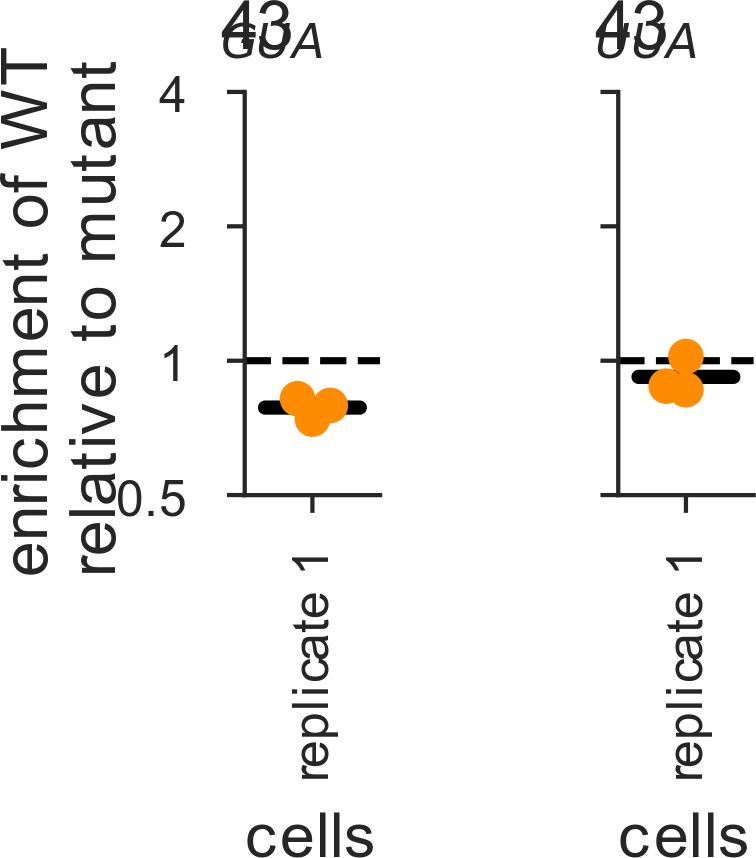

In [41]:
### plotting
sub=df_data[df_data.time=='72']
plot_order=['GTA','TTA']
names=[r'43$_{GUA}$',r'43$_{UUA}$']
fig, ax = plt.subplots()
facet_dict={'ylim':[0.5,3.5]}
sub['biological replicate'] = sub['biological replicate'].apply(pd.to_numeric)
g = sns.factorplot(x="technical replicate", y='enrichment of WT relative to mutant',size=2.2, aspect=.42,hue=None,col="mutant",col_order=plot_order,data=sub, kind="swarm",sharey=True,facet_kws=facet_dict,color='darkorange', s=5)
(g.set_ylabels('').set_xlabels('cells').set(title=''))
median_width=.7
i=0
for axax in g.axes.ravel():
    sample_name=plot_order[i]
    mean_vals=[]
    tick=axax.get_xticks()
    mean_val=sub[(sub['mutant']==sample_name)]['enrichment of WT relative to mutant'].mean()
    mean_vals.append(mean_val)

    axax.axhline(y=1, color='black',linewidth=1,linestyle='--')

    axax.plot([tick-median_width/2, tick+median_width/2], [mean_vals, mean_vals],
           lw=2, color='k')
    axax.set_title(names[i])
    i+=1
    
    axax.set_ylim(float(.5),4)
    axax.set_yscale('log', basey=2)
    axax.set_yticklabels([.25,0.5,1,2,4])

    axax.set_xticklabels(['replicate 1'],rotation=90)
    #plt.xticks(rotation=90)



g.fig.text(0.01, 0.6, 'enrichment of WT \nrelative to mutant', va='center', rotation='vertical')
#axax.set_xticklabels(['replicate 1'])
#plt.xticks(rotation=90)
g.fig.tight_layout(pad=2)

filepath = '../figures/invitro_comp_na43_ratio_of_ratios.svg' 
plt.savefig(filepath)
png = filepath.rstrip('.svg') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=200))
sys.stdout.flush()


/home/hmachkov/venv/hm_py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


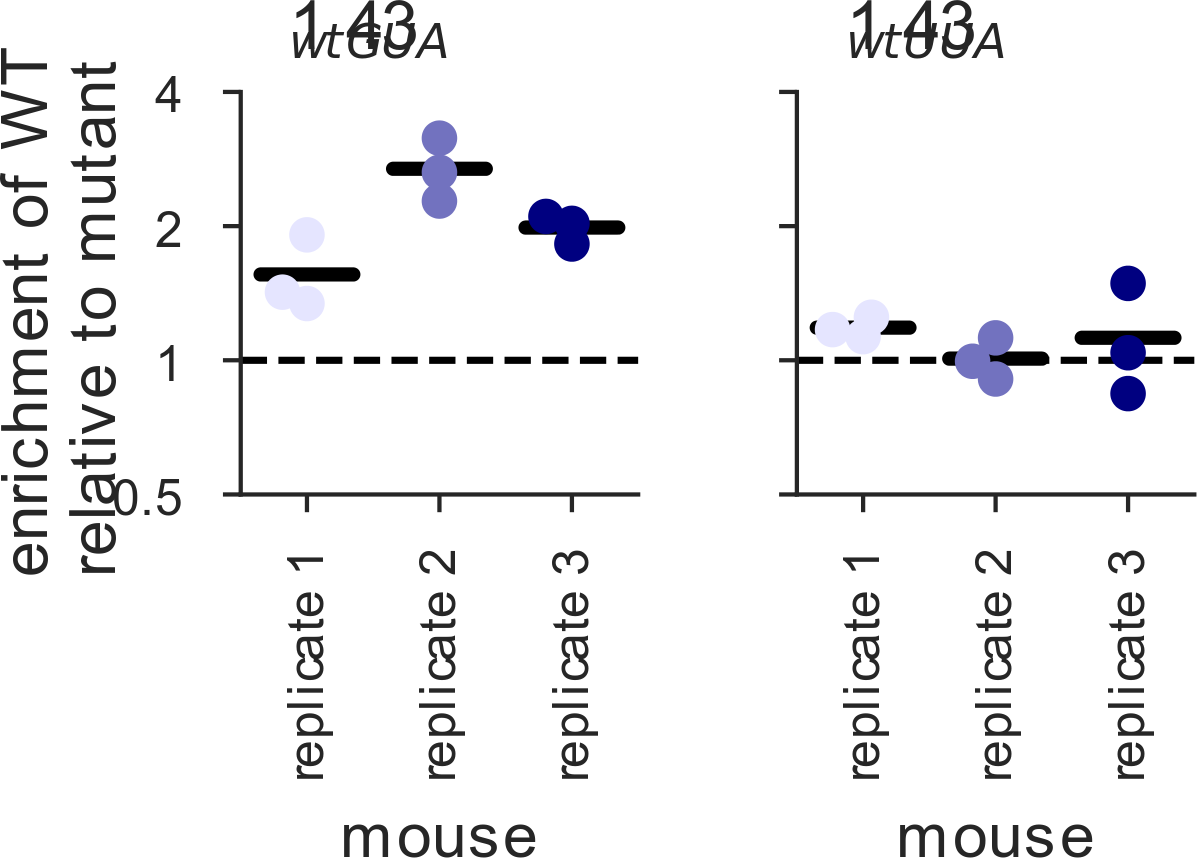

In [27]:
### plotting
sub=df_data[df_data.time=='96']
plot_order=['GTA','TTA']
names=[r'1$_{wt}$ 43$_{GUA}$',r'1$_{wt}$ 43$_{UUA}$']
fig, ax = plt.subplots()
facet_dict={'ylim':[0.5,3.5]}
sub['biological replicate'] = sub['biological replicate'].apply(pd.to_numeric)
#g = sns.factorplot(x="rep", y='ratio end wt: begin wt',hue=None,row="var",row_order=plot_order,data=df_data_invivo, kind="swarm",sharey=True,color='mediumpurple')

g = sns.factorplot(x="biological replicate", y='enrichment of WT relative to mutant',size=2.2, aspect=.6,hue='biological replicate',col="mutant",col_order=plot_order,data=sub, kind="swarm",sharey=True,facet_kws=facet_dict,color='navy', s=5)
(g.set_ylabels('').set_xlabels('mouse').set(title=''))
#g.set_titles("{row_name}")
median_width=.7
i=0
for axax in g.axes.ravel():
    sample_name=plot_order[i]
    mean_vals=[]
    tick=axax.get_xticks()
    
    
    #print tick
    for v in tick:
        #print v+1, sample_name
        mean_val=sub[(sub['mutant']==sample_name)& (sub['biological replicate']==v+1)]['enrichment of WT relative to mutant'].mean()
        #plot horizontal lines across the column, centered on the tick
        #print mean_val
        mean_vals.append(mean_val)
    axax.axhline(y=1, color='black',linewidth=1,linestyle='--')

    axax.plot([tick-median_width/2, tick+median_width/2], [mean_vals, mean_vals],
           lw=2, color='k')
    axax.set_title(names[i])
    axax.set_ylim(float(.5),4)
    axax.set_yscale('log', basey=2)
    axax.set_yticklabels([.25,0.5,1,2,4])

    #axax.set_xticklabels(['replicate 1'],rotation=90)
    i+=1
    axax.set_xticklabels(['replicate 1','replicate 2','replicate 3'],rotation=90)
#plt.xticks(rotation=90)

g.fig.text(0.01, 0.6, 'enrichment of WT \nrelative to mutant', va='center', rotation='vertical')
g.fig.tight_layout(pad=2)

filepath = '../figures/invivo_comp_na43_ratio_of_ratios.svg' 
plt.savefig(filepath)
png = filepath.rstrip('.svg') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=200))
sys.stdout.flush()

## Calculate P value 

compare the endpoint wt: mutant ratio to the beginning wt: mutant ratio. 
for in vitro this is 72 hr cell culture to 10 hr cell culture.
for in vivo this is 96 hr mouse to 10 hr cell culture.
use a paired t-test.
for in vitro, there are 3 pairs corresponding to each biologcial replicate of virus.
for in vivo, I also have 3 pairs. I first took the mean of the log10 transformed values for the 3 technical replicates for each biological replicate of virus, and performed the t-test on the averaged values.


In [42]:
times=['72','96']
mutants=['GTA','TTA']
for time in times:
    for mutant in mutants:
        begin=[]
        end=[]
        if time=='72':
            for sample in dict_count_snp:
                if dict_count_snp[sample]['mutant']==mutant and dict_count_snp[sample]['time']==time:
                        beginsample='cells'+sample[5:-6]+'a_10hr'
                        bottom=dict_count_snp[beginsample]['ratio WT:mutant']
                        top=dict_count_snp[sample]['ratio WT:mutant']
                        bottomval=np.log10(bottom)
                        topval=np.log10(top)
                        begin.append(bottomval)
                        end.append(topval)
            print time, mutant, begin, end,scipy.stats.ttest_rel(begin, end)
            print ''
        if time=='96':
            reps=['1','2','3']
            tech_rep_for_average=[]
            for rep in reps:
                for sample in dict_count_snp:
                    if dict_count_snp[sample]['mutant']==mutant and dict_count_snp[sample]['time']==time and dict_count_snp[sample]['biological replicate']==rep:
                        beginsample='cells'+sample[5:-6]+'a_10hr'
                        bottom=dict_count_snp[beginsample]['ratio WT:mutant']
                        top=dict_count_snp[sample]['ratio WT:mutant']
                        bottomval=np.log10(bottom)
                        topval=np.log10(top)
                        tech_rep_for_average.append(topval)
                ave=np.mean(tech_rep_for_average)
        
                end.append(ave)
                begin.append(bottomval)
            print time, mutant, begin, end,scipy.stats.ttest_rel(begin, end)
            print''


    


72 GTA [0.22271647114758328, -0.084072788302884227, -0.13906337929990631] [0.13735411137073292, -0.1844222516757327, -0.27002571430044436] Ttest_relResult(statistic=7.866474500945472, pvalue=0.01577848394883857)

72 TTA [0.38399478944173282, 0.086003705618381956, -0.20342566678957033] [0.39357520326958756, 0.021189299069938092, -0.26042765554990804] Ttest_relResult(statistic=1.584972626111397, pvalue=0.25384239759954275)

96 GTA [-0.13906337929990631, 0.22271647114758328, -0.084072788302884227] [0.054055777489815542, 0.3534172192600688, 0.30887617939202561] Ttest_relResult(statistic=-3.0207919337155711, pvalue=0.094335773640202403)

96 TTA [0.38399478944173282, 0.086003705618381956, -0.20342566678957033] [0.46292114766625964, 0.27862101220708174, 0.13234253859025105] Ttest_relResult(statistic=-2.7243641296472174, pvalue=0.11245594740549941)



## make supplemental file

In [43]:
sub_list=[]
sub=df_data[df_data.time=='10']
sub=sub.rename(index=str, columns={"mutant counts": "cell culture 10 hr mutant counts",
                               "WT counts": "cell culture 10 hr WT counts",
                              'ratio WT:mutant':'cell culture 10 hr ratio WT to mutant'})
sub_list.append(sub)
sub2=df_data[df_data.time=='72']

sub2=sub2.rename(index=str, columns={"mutant counts": "cell culture 72 hr mutant counts",
                               "WT counts": "cell culture 72 hr WT counts",
                              'enrichment of WT relative to mutant':'cell culture enrichment of WT relative to mutant (72 hr:10 hr)',
                              'ratio WT:mutant':'cell culture 72 hr ratio WT to mutant'})
sub_list.append(sub2)

sub3=df_data[df_data.time=='96']

sub3=sub3.rename(index=str, columns={"mutant counts": "mouse mutant counts",
                               "WT counts": "mouse WT counts",
                              'enrichment of WT relative to mutant':'mouse enrichment of WT relative to mutant (mouse:10 hr cell culture)',
                              'ratio WT:mutant':'mouse ratio WT to mutant'})
sub_list.append(sub3)


In [44]:
horizontalStack=pd.merge(left=sub_list[0],right=sub_list[1], 
                         left_on=['mutant','biological replicate','technical replicate'], 
                         right_on=['mutant','biological replicate','technical replicate'])

horizontalStack=horizontalStack.reset_index()
horizontalStack2=pd.merge(left=horizontalStack,right=sub_list[2], how='right',
                         left_on=['mutant','biological replicate','technical replicate'], 
                          right_on=['mutant','biological replicate','technical replicate'])


df = horizontalStack2[['mutant','biological replicate','technical replicate',
                      'cell culture 10 hr WT counts','cell culture 10 hr mutant counts',
                     'cell culture 10 hr ratio WT to mutant',
                     'cell culture 72 hr WT counts','cell culture 72 hr mutant counts',
                     'cell culture 72 hr ratio WT to mutant',
                     'cell culture enrichment of WT relative to mutant (72 hr:10 hr)',
                    'mouse WT counts','mouse mutant counts',
                    'mouse enrichment of WT relative to mutant (mouse:10 hr cell culture)']]

df2=df.sort_values(['mutant','biological replicate','technical replicate'])
df2['mutant']='1ATG_43_'+df2['mutant']

df2 = df2.fillna('')

df2.to_csv('../tables/S1_table_NA43_competition_summary_table.csv', index=False)